# Data

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
from datetime import datetime
from arch.unitroot import ADF
import statsmodels.api as sm

yf.pdr_override

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (2.3.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


<function yfinance.pdr_override()>

In [2]:
Pair1 = "H"
Pair2 = "MAR"
Start = datetime(2016, 12, 31) #model period
End = datetime(2019, 12, 31)
tradeStart = datetime(2020, 1, 1) #trade period
tradeEnd = datetime(2021, 10, 19)
No_std = 1
No_std_entry = 2
inital_stocks = 1000 #no of initial stocks for X = pair2
initial_cash = 50000 #initial cash



In [3]:
df1_data =pdr.get_data_yahoo(Pair1,start=Start, end= End)
Pair1_close=pd.DataFrame()
df2_data =pdr.get_data_yahoo(Pair2,start= Start, end= End)
Pair2_close=pd.DataFrame()

Pair1_close[Pair1] = pd.DataFrame(df1_data["Close"])
Pair2_close[Pair2] = pd.DataFrame(df2_data["Close"])


SP500 =pdr.get_data_yahoo('SPY',start=tradeStart, end=tradeEnd)
SP500_test=SP500['Close']

In [4]:
def daily_to_monthly(Pair1_close, Pair2_close):
    Pair1_close_month=Pair1_close.resample('m').mean()
    Pair2_close_month=Pair2_close.resample('m').mean()
    return Pair1_close_month, Pair2_close_month

# Whether to change from daily to monthly

In [5]:
#Pair1_close, Pair2_close = daily_to_monthly(Pair1_close, Pair2_close) #Skip this code if using daily price

In [6]:
df = pd.concat([Pair1_close,Pair2_close],axis =1)
df


,H,MAR
Date,,
2017-01-03,55.900002,82.500000
2017-01-04,56.040001,82.339996
2017-01-05,55.250000,81.779999
2017-01-06,54.970001,82.300003
2017-01-09,54.779999,82.250000
...,...,...
2019-12-24,89.739998,151.500000
2019-12-26,90.699997,153.130005
2019-12-27,90.680000,152.729996


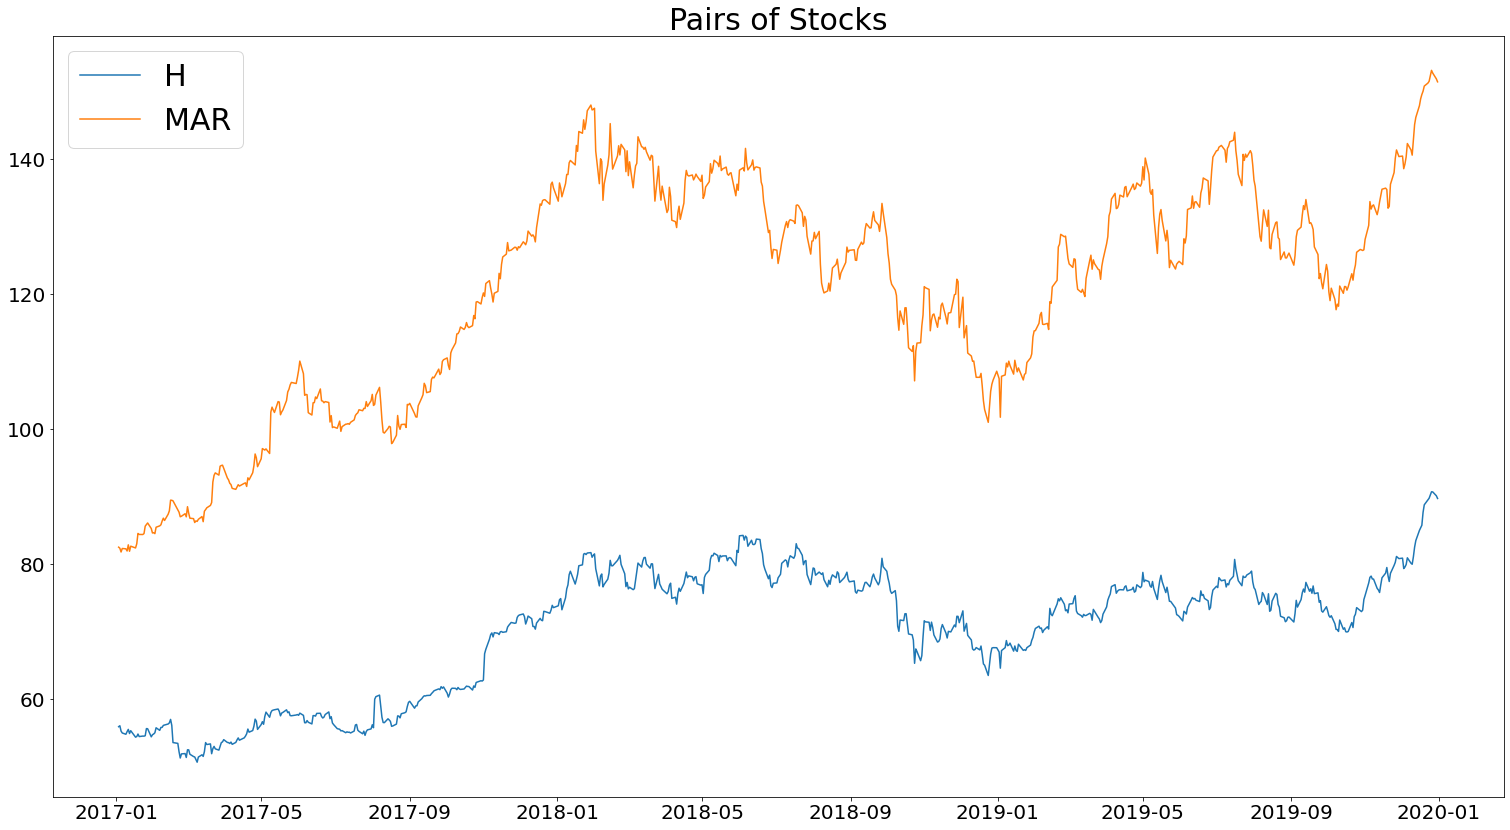

In [7]:
plt.figure(figsize=(26,14))
plt.plot(Pair1_close, label = Pair1 )
plt.plot(Pair2_close, label = Pair2)
plt.title("Pairs of Stocks",
          fontsize = 30)


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)  
plt.legend(fontsize=30)
plt.show()

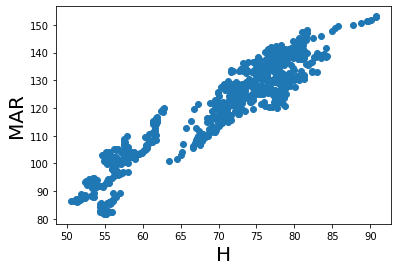

In [8]:
plt.scatter(Pair1_close,Pair2_close)
plt.xlabel(Pair1,fontsize=20)
plt.ylabel(Pair2,fontsize=20)
plt.show()

# Construct Model !

In [9]:
Y = Pair1_close
X = sm.add_constant(Pair2_close)
model = sm.OLS(Y, X)
result = model.fit()
print(result.summary())
print("The intercept is ", result.params[0], "and the slope coefficient is", result.params[1])

                            OLS Regression Results                            
Dep. Variable:                      H   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     6224.
Date:                Thu, 28 Oct 2021   Prob (F-statistic):               0.00
Time:                        06:45:25   Log-Likelihood:                -1920.6
No. Observations:                 754   AIC:                             3845.
Df Residuals:                     752   BIC:                             3854.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9032      0.811      8.515      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


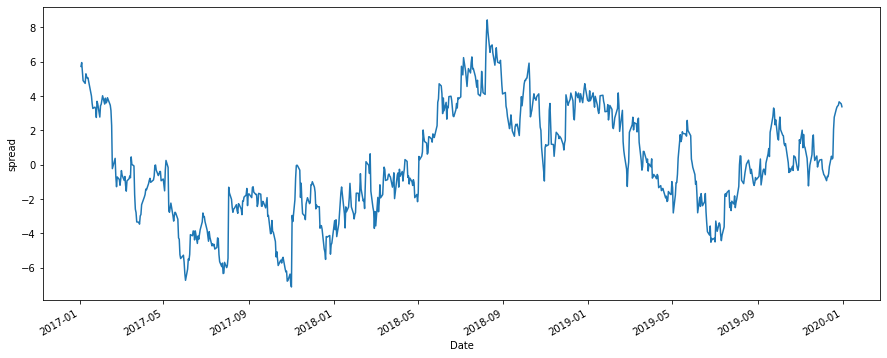

In [10]:
alpha = result.params[0]
beta = result.params[1]
df["spread"] = df[Pair1] - beta *  df[Pair2]- alpha ##The residual term is the price difference series

plt.figure(figsize=(15,6))
df.spread.plot()
plt.ylabel('spread')
plt.show()

# Check Cointegration (Unit root) for spread

In [11]:
from statsmodels.tsa.stattools import adfuller
result_spread =adfuller(df.spread) 
print(result_spread)
if result_spread[1] < 0.05:
    print("Reject H0 (H0: there is unit root) in 95% significance.")
else:
    print("Fail to reject H0 and there is a unit root")

(-3.1647788310852887, 0.022116102044118322, 0, 753, {'1%': -3.4390641198617864, '5%': -2.8653859408474482, '10%': -2.5688179819544312}, 1490.6091887148064)
Reject H0 (H0: there is unit root) in 95% significance.


In [12]:
mu = np.mean(df["spread"])
sd = np.std(df["spread"])
mu, sd

(-1.6585612930209235e-13, 3.0904189185328037)

# Testing Model: 1. Etract testing period data

In [13]:
Tradedf1_data =pdr.get_data_yahoo(Pair1,start=tradeStart, end=tradeEnd)
Trade_pair1_close=pd.DataFrame()
Trade_pair1_close[Pair1] = Tradedf1_data["Close"]
Tradedf2_data =pdr.get_data_yahoo(Pair2,start=tradeStart, end=tradeEnd)
Trade_pair2_close=pd.DataFrame()
Trade_pair2_close[Pair2] = Tradedf2_data["Close"]



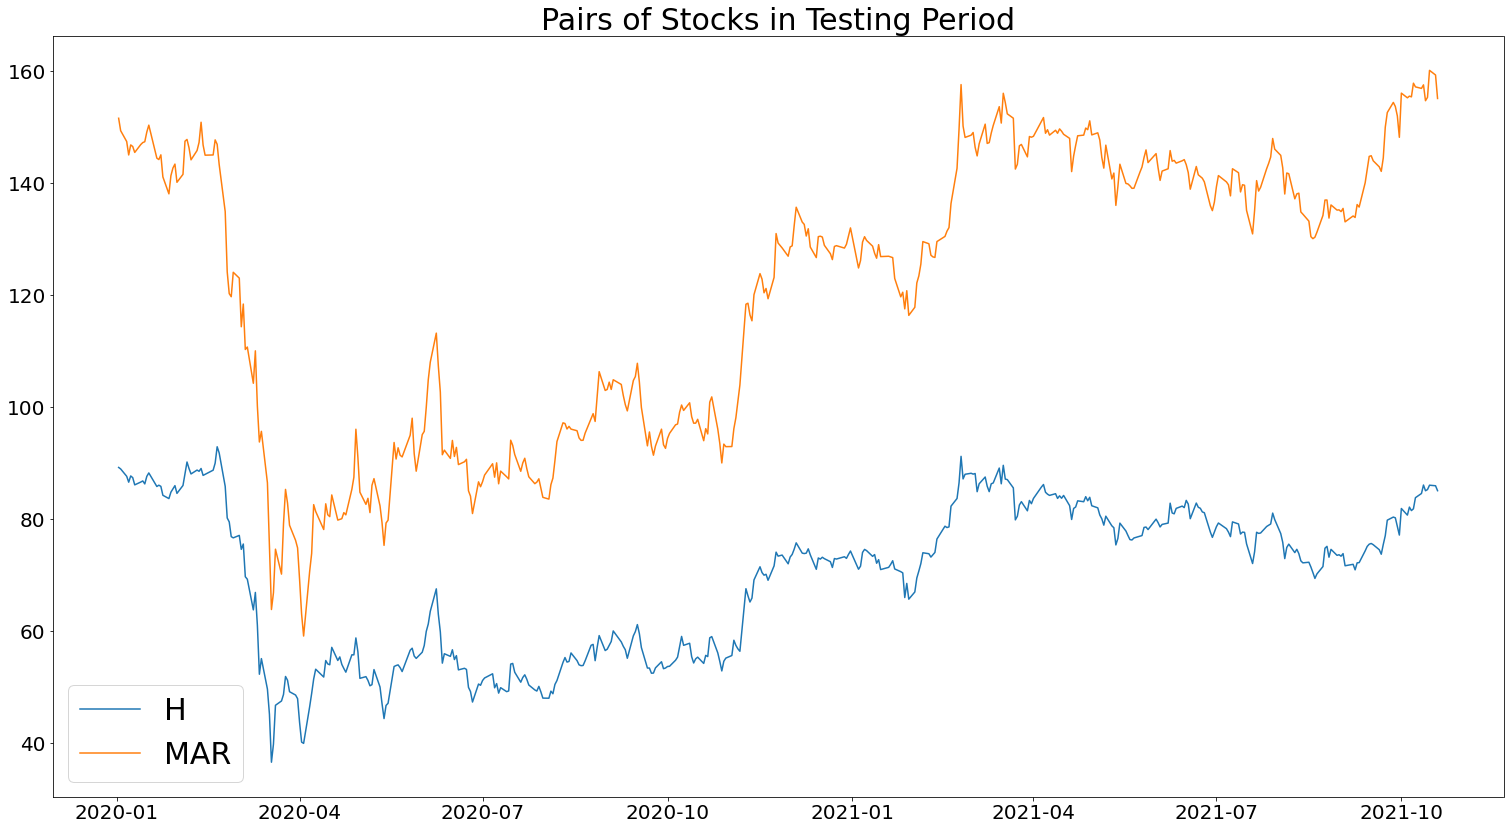

In [14]:
plt.figure(figsize=(26,14))
plt.plot(Trade_pair1_close, label = Pair1 )
plt.plot(Trade_pair2_close, label = Pair2)
plt.title("Pairs of Stocks in Testing Period",
          fontsize = 30)


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)  
plt.legend(fontsize=30)
plt.show()


# 2.Check spread and its unit  root?

Text(0.5, 1.0, 'Spread for Out-Sample Data')

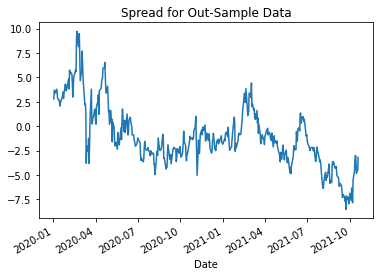

In [15]:
df_test= pd.concat([Trade_pair1_close,Trade_pair2_close],axis=1)
df_test.columns=[Pair1,Pair2]
df_test['Spread']=df_test[Pair1]- beta *df_test[Pair2 ]- alpha

plt.plot(figsize = (26, 14))
df_test['Spread'].plot()
plt.title("Spread for Out-Sample Data")

In [16]:
signals=pd.DataFrame(index=df_test.index)
signals[Pair1]=df_test[Pair1]
signals[Pair2]=df_test[Pair2]
mu = df["spread"].mean()
sd = df["spread"].std()

signals['mean']=df['spread'].mean()

signals['Upper limit']=df_test['Spread']*0+ mu + No_std * sd
signals['Lower limit']=df_test['Spread']*0+ mu - No_std * sd

signals['2nd Upper limit']=df_test['Spread']*0+ mu + (No_std + 1) * sd
signals['2nd Lower limit']=df_test['Spread']*0+ mu - (No_std + 1) * sd

signals['3rd Upper limit']=df_test['Spread']*0+ mu + (No_std + 2) * sd
signals['3rd Lower limit']=df_test['Spread']*0+ mu - (No_std + 2) * sd

signals['spread']=df_test['Spread']
signals

,H,MAR,mean,Upper limit,Lower limit,2nd Upper limit,2nd Lower limit,3rd Upper limit,3rd Lower limit,spread
Date,,,,,,,,,,
2020-01-02,89.169998,151.490005,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,2.802475
2020-01-03,88.900002,149.270004,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,3.696983
2020-01-06,87.589996,147.339996,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,3.399366
2020-01-07,86.540001,144.940002,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,3.608291
2020-01-08,87.650002,146.729996,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,3.779348
...,...,...,...,...,...,...,...,...,...,...
2021-10-13,85.010002,154.619995,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,-2.999361
2021-10-14,85.220001,155.220001,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,-3.104096
2021-10-15,86.000000,160.039993,-1.658561e-13,3.09247,-3.09247,6.184941,-6.184941,9.277411,-9.277411,-4.852431


(18262.0, 18919.0)

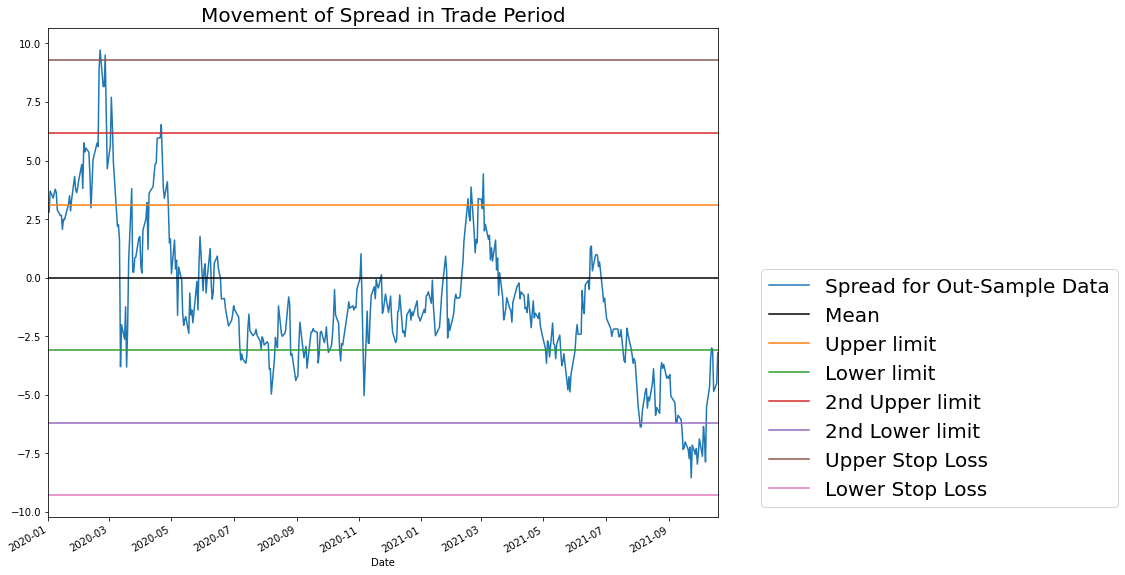

In [17]:
plt.subplots(figsize=(12,10))

df_test['Spread'].plot(label='Spread for Out-Sample Data')
signals['mean'].plot(label='Mean', color = "black")
signals['Upper limit'].plot(label='Upper limit')
signals['Lower limit'].plot(label='Lower limit')
signals['2nd Upper limit'].plot(label='2nd Upper limit')
signals['2nd Lower limit'].plot(label='2nd Lower limit')
signals['3rd Upper limit'].plot(label='Upper Stop Loss')
signals['3rd Lower limit'].plot(label='Lower Stop Loss')

plt.title('Movement of Spread in Trade Period', fontsize = 20)
plt.legend(bbox_to_anchor=(1.05, 0),loc=3, fontsize = 20)
plt.xlim(tradeStart,tradeEnd)


# Trading Strategy

In [18]:
level = (float('-inf'), mu - 3*sd , mu - No_std_entry * sd, 0,
         mu + No_std_entry * sd,  mu + 3*sd,float('inf'))
level

(-inf,
 -9.27741092604433,
 -6.184940617362943,
 0,
 6.184940617362611,
 9.277410926044,
 inf)

In [19]:
spd=df_test['Spread']
Interval_range= pd.cut(spd,level,labels=False)
Interval_range

Date
2020-01-02    3
2020-01-03    3
2020-01-06    3
2020-01-07    3
2020-01-08    3
             ..
2021-10-13    2
2021-10-14    2
2021-10-15    2
2021-10-18    2
2021-10-19    2
Name: Spread, Length: 454, dtype: int64

In [20]:
def Signal_Trading(Interval_range):
    n = len(Interval_range)
    signal = np.zeros(n)
    for i in range(1,n):
        if Interval_range[i-1] == 3 and Interval_range[i] == 4:           # The spread goes up from Zone 3 to Zone 4, and positions are opened in the opposite direction
            signal[i] = -2
        elif Interval_range[i-1] == 3 and Interval_range[i] == 2:        # The spread goes from zone 3 to zone 2, and the position is closed
            signal[i] = 2
        elif Interval_range[i-1] == 4 and Interval_range[i] == 5:        # The spread from zone 4to zone 5, that is, it breaks through zone 3, and the position is closed
            signal[i] = 3
        elif Interval_range[i-1] == 2 and Interval_range[i] == 1:     # The spread from zone 2 to zone 1 goes down, and a position is opened in the positive direction
            signal[i] = 1
        elif Interval_range[i-1] == 2 and Interval_range[i] == 3:      # The spread from zone 2 to zone 3, and the position is closed
            signal[i] = -1
        elif Interval_range[i-1] == 1 and Interval_range[i] == 0:     # The spread from the 1 zone to the 0 zone, that is, it breaks through the -3 zone, and the position is closed
            signal[i] = -3
    return(signal)

In [21]:
signal=Signal_Trading(Interval_range)
position = [signal[0]]
ns = len(signal)

for i in range(1,ns):
    position.append(position[-1])
    if signal[i] == 1:
        position[i] = 1                 # The spread goes down from zone -1 to zone -2, and a positive position is opened: buy B and sell A <------ (the spread is B-A)
    elif signal[i] == -2:
        position[i] = -1               # The spread goes from zone 1 to zone 2, and the position is reversed: Sell B, buy A <------(The spread is B-A)
    elif signal[i] == -1 and position[i-1] == 1:
        position[i] = 0                # close
    elif signal[i] == 2 and position[i-1] == -1:
        position[i] = 0               # close
    elif signal[i] == 3:
        position[i] = 0              # close
    elif signal[i] == -3:
        position[i] = 0             # close
        
position = pd.Series(position, index=df_test.index)
position

Date
2020-01-02    0.0
2020-01-03    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
             ... 
2021-10-13    1.0
2021-10-14    1.0
2021-10-15    1.0
2021-10-18    1.0
2021-10-19    1.0
Length: 454, dtype: float64

In [22]:
def Trade(priceX,priceY,position):
    n = len(position)
    size = inital_stocks                  #assume 1000 stocks of Pair2 Stock
    shareX = -size * position
    beta=result.params[1]
    shareY = [ shareX[0] / (-beta)]     
    
    cash = [initial_cash] #original capital 10%-20% deposit for Holding 1000 Pair1 Stock

       
    for i in range(1,n):
        shareY.append(shareY[i-1])
        cash.append(cash[i-1])
        
        
        if position[i-1] == 0 and position[i] == 1: # long position
            shareY[i] = shareX[i] / (-beta)
            cash[i] = cash[i-1]-(shareX[i]*priceX[i]+shareY[i]*priceY[i])
       
        elif position[i-1] == 0 and position[i] == -1:
            shareY[i] = shareX[i] / (-beta)
            cash[i] = cash[i-1]-(shareX[i]*priceX[i]+shareY[i]*priceY[i]) #short position 
      
        elif position[i-1] == 1 and position[i] == 0:
            shareY[i] = 0
            cash[i] = cash[i-1]+(shareX[i-1]*priceX[i]+shareY[i-1]*priceY[i])
      
        elif position[i-1] == -1 and position[i] == 0:
            shareY[i] = 0
            cash[i] = cash[i-1]+(shareX[i-1]*priceX[i]+shareY[i-1]*priceY[i])
         
    cash = pd.Series(cash,index=position.index)
    
    shareX = pd.Series(shareX,index=position.index)
    shareY = pd.Series(shareY,index=position.index)
    
    Equity = cash + shareX*priceX + shareY*priceY
    
    account = pd.DataFrame({'Position':position,'HAL_Price':priceY,'XOM_Price':priceX,'HAL_Share':shareY,'XOM_Share':shareX,'Cash':cash,'Equity':Equity},index=df_test.index)
    return(account)

In [23]:
account = Trade(signals[Pair2],signals[Pair1],position)

account['Equity'][0]
account

,Position,HAL_Price,XOM_Price,HAL_Share,XOM_Share,Cash,Equity
Date,,,,,,,
2020-01-02,0.0,89.169998,151.490005,0.000000,-0.0,50000.000000,50000.000000
2020-01-03,0.0,88.900002,149.270004,0.000000,-0.0,50000.000000,50000.000000
2020-01-06,0.0,87.589996,147.339996,0.000000,-0.0,50000.000000,50000.000000
2020-01-07,0.0,86.540001,144.940002,0.000000,-0.0,50000.000000,50000.000000
2020-01-08,0.0,87.650002,146.729996,0.000000,-0.0,50000.000000,50000.000000
...,...,...,...,...,...,...,...
2021-10-13,1.0,85.010002,154.619995,1906.390938,-1000.0,84931.229684,92373.532303
2021-10-14,1.0,85.220001,155.220001,1906.390938,-1000.0,84931.229684,92173.866552
2021-10-15,1.0,86.000000,160.039993,1906.390938,-1000.0,84931.229684,88840.857091


# Performance measurement

In [24]:
def Equity_Ratio(Equity,position):
    n = len(Equity)
    size = 1000                   # assume we hold 1000 shares of Pair2 Stock  
    ER=[1]
    for i in range(1,n):
        ER.append(ER[i-1])
        ER[i]=(Equity[i]/Equity[0])       

    ER = pd.Series(ER,index=position.index,dtype=np.float)

    return(ER)

## Benchmark

In [25]:
SP500_test

Date
2020-01-02    324.869995
2020-01-03    322.410004
2020-01-06    323.640015
2020-01-07    322.730011
2020-01-08    324.450012
                 ...    
2021-10-13    435.179993
2021-10-14    442.500000
2021-10-15    445.869995
2021-10-18    447.190002
2021-10-19    450.640015
Name: Close, Length: 454, dtype: float64

In [26]:
account['Equity_Ratio']=Equity_Ratio(account['Equity'],position)

Portfolio = pd.DataFrame()
Portfolio['%s and %s pair trading' %(Pair1, Pair2)]=Equity_Ratio(account['Equity'],position)
Portfolio['SP500']=Equity_Ratio(SP500_test,position)

Portfolio

,H and MAR pair trading,SP500
Date,,
2020-01-02,1.000000,1.000000
2020-01-03,1.000000,0.992428
2020-01-06,1.000000,0.996214
2020-01-07,1.000000,0.993413
2020-01-08,1.000000,0.998707
...,...,...
2021-10-13,1.847471,1.339551
2021-10-14,1.843477,1.362083
2021-10-15,1.776817,1.372457


Text(0, 0.5, 'Equity Ratio')

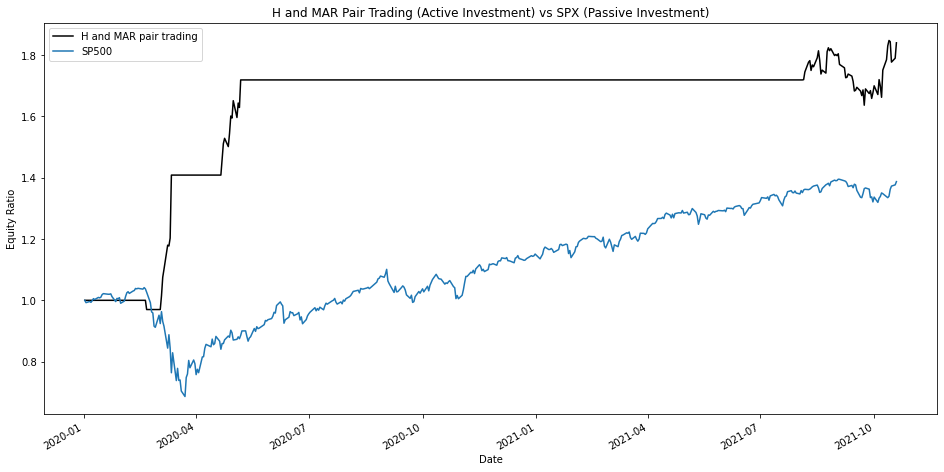

In [27]:
Portfolio.loc[:,:].plot(style=['k'], figsize=(16,8))
plt.title('%s and %s Pair Trading (Active Investment) vs SPX (Passive Investment)'%(Pair1, Pair2))
plt.ylabel('Equity Ratio')